# Eikonal equation

In this notebook, we compute geodesic distances using the Eikonal equation

$$
\begin{aligned}
    \sqrt{\nabla_S u \cdot \nabla_S u} &= 1, \\
    u(\boldsymbol{x}_b) &= 0,
\end{aligned}
$$

where $\nabla_S u := \nabla u - (\mathbf{n}\cdot\nabla u)\mathbf{n}$ is the surface gradient. This equation has multiple applications, for instance, in cardiac electrophysiology and seismology, because it can be used to model the arrival times of a traveling wave. In the particular form shown, the solution $u(\boldsymbol{x})$ can be interpreted as the geodesic distance from the point $\boldsymbol{x}_b$ to any point $\boldsymbol{x}$ on the manifold.

In this example, we will solve this equation on the surface of a coil, which is generated by an helix with 30 mm of diameter and 12 mm per revolution of pitch. This curve is extruded with a circular cross-section with 5 mm of radius. We can generate a ground truth solution of the Eikonal equation by randomly selecting a point on the mesh for $\boldsymbol{x}_b$ and then applying the exact geodesic algorithm as implemented in libigl. We randomly select 50 points of this solution to use as data $u_i$. In this case, the partial differential equation loss takes the form

$$
    \operatorname{MSE}_{\rm PDE}(\boldsymbol{\theta}) = \frac{1}{R}\sum_i^R \left(\sqrt{({\boldsymbol{B}^e_r}\hat{\boldsymbol{u}}^e_r) \cdot (\boldsymbol{B}^e_r \hat{\boldsymbol{u}}^e_r)}-1\right)^2,
$$

where $\boldsymbol{B}^e_r\hat{\boldsymbol{u}}^e_r$ is the approximation of the surface gradient for a particular triangle $r$. Here, the vector $\hat{\boldsymbol{u}}^e_r$ is the prediction of the neural network at the nodes of the triangle $r$, which depends on the trainable parameters $\boldsymbol{\theta}$. We remark that we do not impose the initial condition in the loss function, thus the problem is ill-posed and must be supplemented with data points.


In [ ]:
from jaxpinns.base import PINN
%load_ext autoreload
%autoreload 2
import numpy as onp
import jax.numpy as np
from jax import random, vmap
from jax import config
from scipy.linalg import eigh
config.update("jax_enable_x64", True)


import matplotlib.pyplot as plt
import matplotlib.cm as cm


from jax import random, grad, jit, vmap
from jax.tree_util import Partial as partial
import numpy as onp

from Mesh import Mesh
import igl

import jax.numpy as np

from jaxpinns.samplers import Sampler
from jax.example_libraries import optimizers


from jaxpinns.architectures import MLP
from jaxpinns.optimizers import adam
from jaxpinns.loggers import logger

import matplotlib.pyplot as plt

from torch.utils import data

import pickle

onp.random.seed(1234)
rng_key = random.PRNGKey(0) 



load data and compute the eigenfunctions

In [2]:
from Mesh import Mesh
from scipy.linalg import eigh
m = Mesh('data/coil_1.2_MM.obj')

centroid = m.verts.mean(0)
std_max = m.verts.std(0).max()

verts_new = (m.verts - centroid)/std_max

m = Mesh(verts = verts_new, connectivity = m.connectivity)

print('Computing Laplacian')
K, M = m.computeLaplacian()
print('Computing eigen values')
eigvals, eigvecs = eigh(K,M)

Computing Laplacian
Computing eigen values


In [6]:
K

array([[3.51711191, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 3.50233314, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 3.44466485, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 3.47733189, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 3.52553825,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        3.62023173]], shape=(1546, 1546))

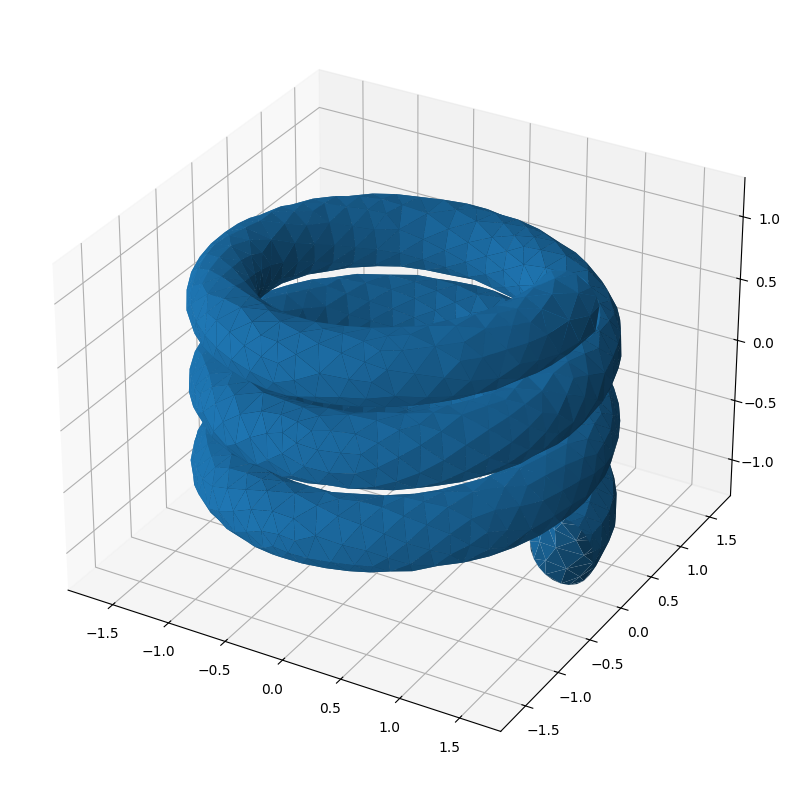

In [3]:
ax =  plt.figure(figsize=(10,10)).add_subplot(projection='3d')
surf = ax.plot_trisurf(m.verts[:,0], m.verts[:,1], m.verts[:,2], triangles = m.connectivity)
plt.show()

save eigenfunctions for visualization. `.vtu` files can be opened with paraview

In [4]:
import meshio

cells = [('triangle', m.connectivity)]
m_out = meshio.Mesh(m.verts, cells,point_data={'v1': eigvecs[:,1], 'v10': eigvecs[:,10], 'v50': eigvecs[:,50], 'v100': eigvecs[:,100]})

m_out.write('output/coil_eigfuncs.vtu')

In [5]:
class LaplacePINN(PINN):
    # Initialize the class
    def __init__(self, eigenfuncs, connectivity, mesh_operator, norm_const, mu_X = 0.0, sigma_X = 1.0):
        super().__init__(mu_X, sigma_X)

        self.eigenfuncs = np.array(eigenfuncs)
        self.connectivity = connectivity
        self.mesh_operator = mesh_operator
        self.Xc = self.eigenfuncs[self.connectivity.flatten(),:]

        self.mu_y = norm_const['mu_y']
        self.sigma_y = norm_const['sigma_y']
        self.num_loss_terms = 2

    # Make sure this accepts a single input data-point and returns a scalar!
    # Then use vmap to vectorize
    def net_u(self, params, x):
        inputs = np.stack([x])
        u = self.net_apply(params, inputs)
        return u[0]



    @partial(jit, static_argnums=(0))
    def eiknorm(self, BB, u):
        return np.sqrt(np.dot(u, np.dot(BB, u)))

    @partial(jit, static_argnums=(0,))
    def loss_u(self, params, batch):
        # Fetch data
        inputs, targets = batch
        X, _, _ = inputs
        Y, _ = targets
        # Evaluate model
        u_fn = lambda x: self.net_u(params, x)
        u_pred = vmap(u_fn)(X)
        # Compute loss
        loss_u = np.mean((Y - u_pred)**2)
        return loss_u

    @partial(jit, static_argnums=(0,))
    def loss_r(self, params, batch):
        # Fetch data
        inputs, targets = batch
        _, X_res, Bs = inputs
        _, Y_res = targets

        u_fn = lambda x: self.net_u(params, x)
        yc = vmap(u_fn)(X_res).reshape((-1,3))
        res = vmap(self.eiknorm)(Bs, yc*self.sigma_y + self.mu_y)
        # Compute loss
        loss_r = np.mean((Y_res - res[:,None])**2)
        return loss_r

    def loss(self, params, batch, weights=(1.0,1.0)):
        w_u, w_r = weights
        loss_u = self.loss_u(params, batch)
        loss_r = self.loss_r(params, batch)
        loss = w_u*loss_u + w_r*loss_r
        return loss



    # Evaluates predictions at test points
    @partial(jit, static_argnums=(0,))
    def predict(self, params, X_star):
        X_star = (X_star - self.mu_X) / self.sigma_X
        u_fn = lambda x: self.net_u(params, x)
        u_star = vmap(u_fn)(X_star)
        return u_star




class LaplacePINNGenerator(data.Dataset):
    def __init__(self, X, Y, eigenfuncs, connectivity, mesh_operator,
                 batch_size=1, rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.X = X
        self.Y = Y
        self.eigenfuncs = eigenfuncs
        self.connectivity = connectivity
        self.mesh_operator = mesh_operator
        self.batch_size = batch_size
        self.key = rng_key

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        inputs, targets = self.__data_generation(subkey)
        return inputs, targets

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.X.shape[0], (self.batch_size,), replace = False)
        idx_e = random.choice(key, self.mesh_operator.shape[0], (self.batch_size,), replace = False)

        Xc = self.eigenfuncs[np.ravel(self.connectivity[idx_e]),:]

        # Make inputs, outputs
        inputs  = (self.X[idx], Xc, self.mesh_operator[idx_e])
        outputs = (self.Y[idx], np.ones((self.batch_size,1)))
        return inputs, outputs

generate the ground truth solution

In [6]:
Y_eg = igl.exact_geodesic(m.verts, m.connectivity, onp.array([0]), onp.array([]), onp.arange(m.verts.shape[0]), onp.array([]))

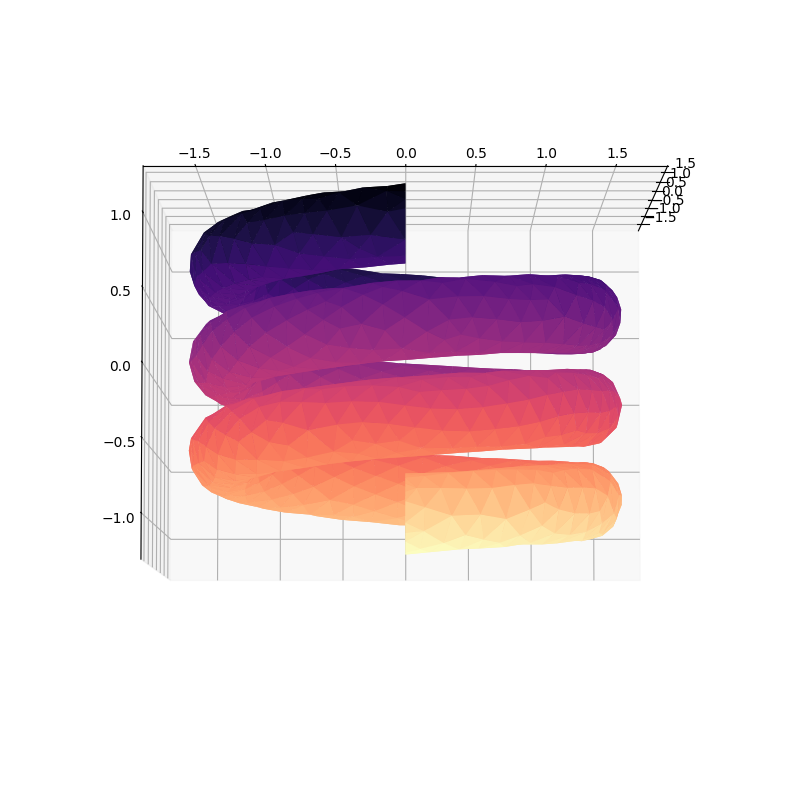

In [11]:
# Your geodesic distances
d = Y_eg  

# Option 1: direct distance-based coloring (smooth gradient)
face_colors = d[m.connectivity].mean(axis=1)
face_colors = cm.magma_r(face_colors)

# Set cmap
cmap = "magma_r"


# Plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection="3d")
surf = ax.plot_trisurf(
    m.verts[:, 0],
    m.verts[:, 1],
    m.verts[:, 2],
    triangles=m.connectivity,
    cmap=cmap,
    facecolors=face_colors,
    shade=False,
    linewidth=0.2,
    antialiased=True
)

ax.view_init(elev=-5, azim=0)

plt.show()


In [14]:
with open("pinn_approximated_eigs.pkl", "rb") as f:
    pinn_approximated_eigs = pickle.load(f)

In [15]:
pinn_eigvals = pinn_approximated_eigs["eigvals"]
pinn_eigvecs = pinn_approximated_eigs["eigvecs"]

select a subset of points for training data

In [16]:
n_nodes = m.verts.shape[0]
N = 50 # number of data points
rng_key, subkey = random.split(rng_key)
idx_train = random.choice(random.PRNGKey(30), n_nodes, (N,), replace = False)


In [48]:
n_eigs = 50 # number of eigenfunctions

# eigfuncs = eigvecs[:,:n_eigs]
eigfuncs = pinn_eigvecs[:,:n_eigs]

coords = m.verts

Y = Y_eg[idx_train,None]
sigma_y = Y.std()
mu_y = Y.mean()
Y = (Y - mu_y)/sigma_y

norm_const = {'mu_y': mu_y, 'sigma_y': sigma_y}

Bs = []

for e in range(m.connectivity.shape[0]):
    B, J = m.Bmatrix(e)
    Bs.append(np.dot(B.T, B)/J**2)

Bs = np.array(Bs) 

The elements of `Bs` are used to compute the norm of the gradient for the eikonal equation, such that

$$\|\nabla u \| = \sqrt{\boldsymbol{u}^e \boldsymbol{B} \boldsymbol{u}^e}$$

$\boldsymbol{u}^e$ is a vector containing the nodal predictions of the network for a given element. 

This operation is implemented in the function `eiknorm`. 

In [49]:
dataset = LaplacePINNGenerator(np.array(eigfuncs[idx_train,:]), np.array(Y), np.array(eigfuncs), np.array(m.connectivity), Bs, batch_size=10)

In [50]:
model = LaplacePINN(eigfuncs, m.connectivity, Bs, norm_const)


In [51]:
# Setup architecture
init_key = random.PRNGKey(0)
layers = [n_eigs, 100, 1]
args = (layers,)
model.architecture(MLP, *args, init_key=init_key)

In [52]:
# Setup optimizer
saved_state = None
# saved_state = 'chkpt_it_10000.npy'
learning_rate = optimizers.exponential_decay(1e-3, decay_steps=100, decay_rate=1.0)
args = (learning_rate, model.loss)
model.optimizer(adam, *args, saved_state=saved_state)

In [53]:
# Setup logger
io_keys = ['loss','loss_u','loss_r']
log_keys = ['loss','loss_u','loss_r']
log_funs = [model.loss, model.loss_u, model.loss_r]
args = (io_keys, log_keys, log_funs)
model.logger(logger, *args, io_step = 2000)

In [54]:
# Train
#validation_data = (X_star, u_star)
model.train(dataset, nIter = 40000, ntk_weights = False)

  0%|          | 0/40000 [00:00<?, ?it/s]

100%|██████████| 40000/40000 [00:25<00:00, 1554.00it/s, loss=0.030590423470428688, loss_u=0.0009390698174332609, loss_r=0.029651353652995427]


mean squared error 0.001551991909014219


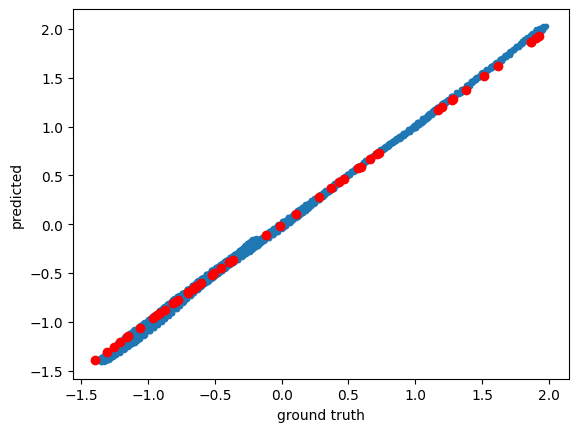

In [ ]:
########################### EXACT EIGENVECTORS ###########################
##########################################################################
##########################################################################

opt_params = model.get_params(model.opt_state)
u_pred = model.predict(opt_params, eigfuncs)


MSE = np.mean(((Y_eg[:,None] - mu_y)/sigma_y - u_pred)**2)
plt.plot((Y_eg - mu_y)/sigma_y , u_pred,'.')
plt.scatter(Y , Y, c = 'r', zorder = 100, label = 'data')
plt.xlabel('ground truth')
plt.ylabel('predicted')
print("mean squared error", MSE)


mean squared error 0.0018530569423288105


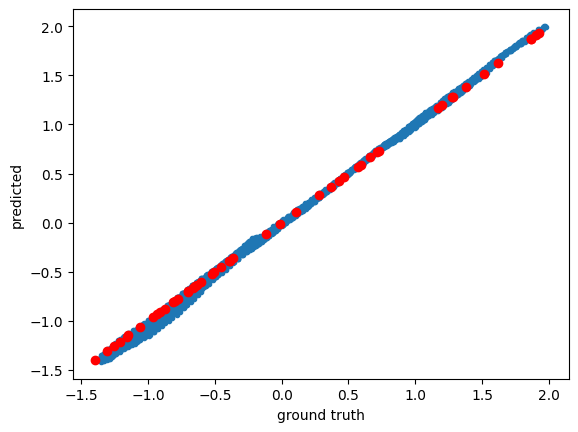

In [55]:
########################### PINNs EIGENVECTORS ###########################
##########################################################################
##########################################################################

opt_params = model.get_params(model.opt_state)
u_pred = model.predict(opt_params, eigfuncs)


MSE = np.mean(((Y_eg[:,None] - mu_y)/sigma_y - u_pred)**2)
plt.plot((Y_eg - mu_y)/sigma_y , u_pred,'.')
plt.scatter(Y , Y, c = 'r', zorder = 100, label = 'data')
plt.xlabel('ground truth')
plt.ylabel('predicted')
print("mean squared error", MSE)


In [ ]:
import meshio

cells = [('triangle', m.connectivity)]
m_out = meshio.Mesh(m.verts, cells,point_data={'Delta-pinn': u_pred*sigma_y + mu_y, 'exact': Y_eg})

m_out.write('output/Delta-PINN_eikonal.vtu')

In [61]:
Y_pred.shape

(1546, 1)

In [58]:
Y_pred_pinn

Array([[0.00681554],
       [0.83076091],
       [1.56773812],
       ...,
       [4.91305544],
       [5.28290257],
       [5.62834593]], dtype=float64)

In [63]:
np.sqrt(np.mean((Y_eg - Y_pred.squeeze())**2))

Array(0.19039502, dtype=float64)

In [64]:
np.sqrt(np.mean((Y_eg - Y_pred_pinn.squeeze())**2))

Array(0.20804402, dtype=float64)

In [31]:
Y_eg

array([0.        , 0.88687736, 1.70351452, ..., 4.8549571 , 5.19632752,
       5.42171308], shape=(1546,))

In [ ]:
# Y_pred = (sigma_y * u_pred) + mu_y

In [56]:
Y_pred_pinn = (sigma_y * u_pred) + mu_y

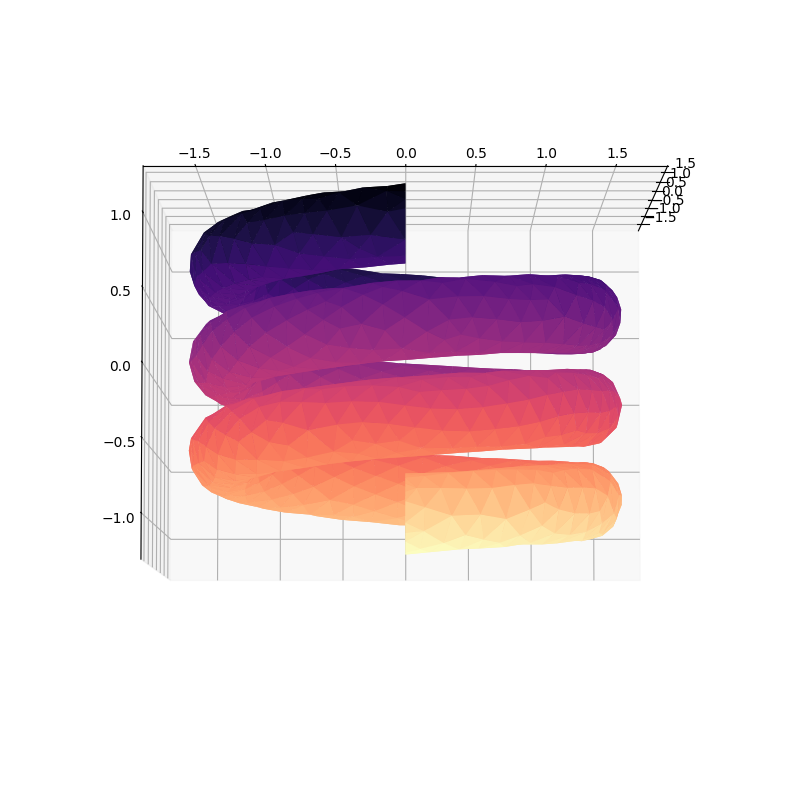

In [ ]:
########################### EXACT EIGENVECTORS ###########################
##########################################################################
##########################################################################

# Your geodesic distances
d = Y_pred

# Option 1: direct distance-based coloring (smooth gradient)
face_colors = d[m.connectivity].mean(axis=1)
face_colors = cm.magma_r(face_colors)

# Set cmap
cmap = "magma_r"


# Plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection="3d")
surf = ax.plot_trisurf(
    m.verts[:, 0],
    m.verts[:, 1],
    m.verts[:, 2],
    triangles=m.connectivity,
    cmap=cmap,
    facecolors=face_colors,
    shade=False,
    linewidth=0.2,
    antialiased=True
)

ax.view_init(elev=-5, azim=0)

plt.show()


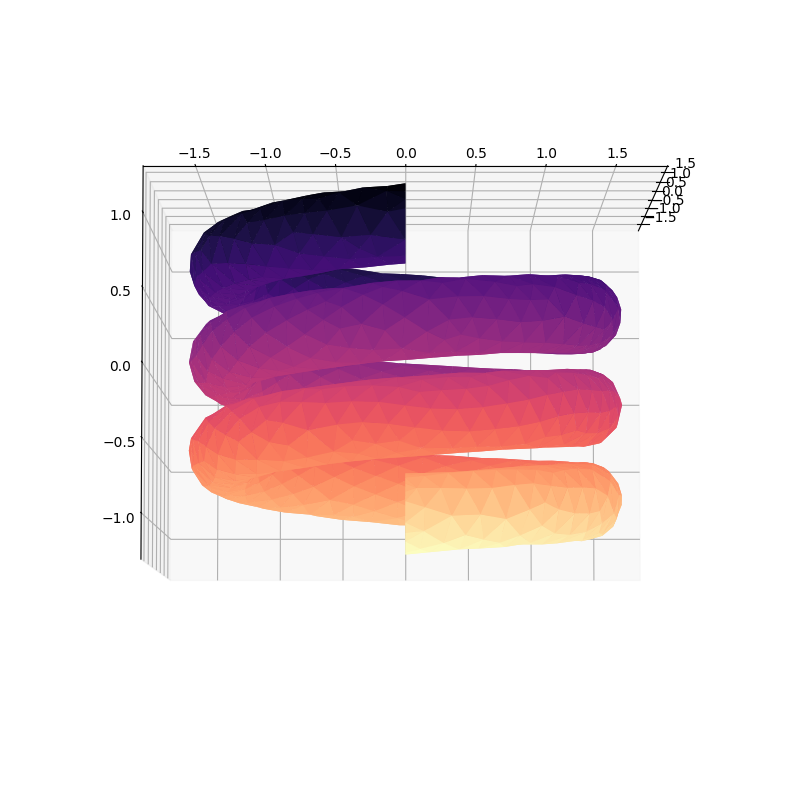

In [59]:
########################### PINNs EIGENVECTORS ###########################
##########################################################################
##########################################################################

# Your geodesic distances
d = Y_pred_pinn

# Option 1: direct distance-based coloring (smooth gradient)
face_colors = d[m.connectivity].mean(axis=1)
face_colors = cm.magma_r(face_colors)

# Set cmap
cmap = "magma_r"


# Plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection="3d")
surf = ax.plot_trisurf(
    m.verts[:, 0],
    m.verts[:, 1],
    m.verts[:, 2],
    triangles=m.connectivity,
    cmap=cmap,
    facecolors=face_colors,
    shade=False,
    linewidth=0.2,
    antialiased=True
)

ax.view_init(elev=-5, azim=0)

plt.show()
